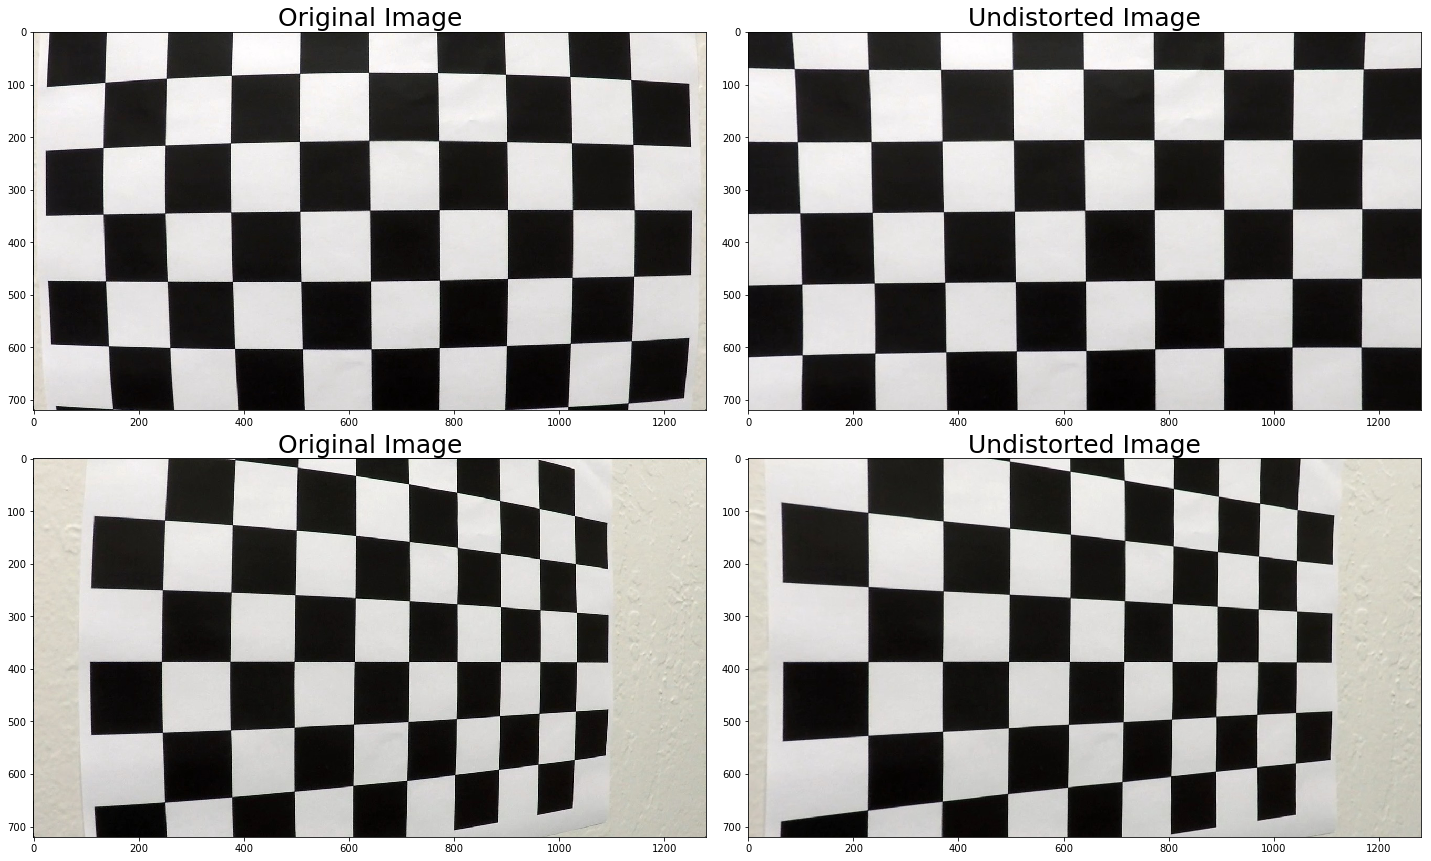

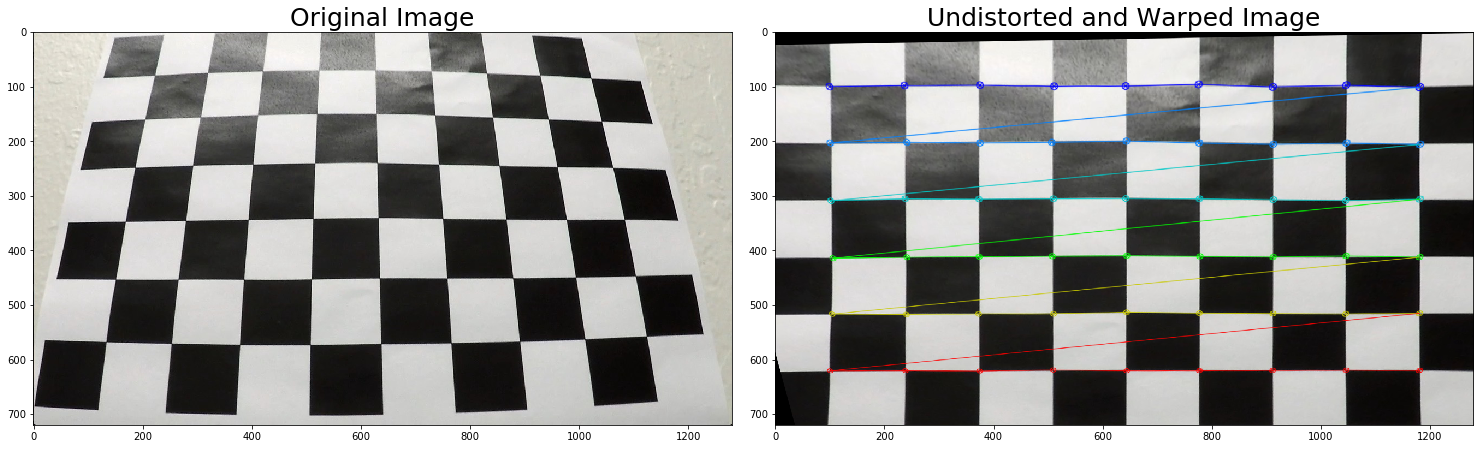

In [16]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import glob

#############################
####### Loading Images ######
#############################

test_images_names = ['straight_lines1.jpg','straight_lines2.jpg','test1.jpg','test2.jpg','test3.jpg',\
                    'test4.jpg','test5.jpg','test6.jpg'] 
test_images_dir = './test_images/'

test_images = []

for image_name in test_images_names:
    image = mpimg.imread(test_images_dir + image_name)
    test_images.append(image)

test_images = np.array(test_images)

cal_images_dir = './camera_cal/'
calibration_images = []

for image_name in glob.glob(cal_images_dir + 'calibration*.jpg'):
    im = mpimg.imread(image_name)
    calibration_images.append(im)

calibration_images = np.array(calibration_images)

##############################
### Camera Calibration #######
##############################

# Prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....(8,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for cal_image in calibration_images:
    gray_cal_image = cv2.cvtColor(cal_image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_cal_image, (nx, ny), None)

    # If found, draw corners, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        #plt.figure()
        #cv2.drawChessboardCorners(cal_image, (nx, ny), corners, ret)
        #plt.imshow(cal_image)
        #plt.show()
    else:
        #plt.figure()
        #print('Corners not identified for this image')
        #plt.imshow(cal_image)
        #plt.show()
        pass

# Camera Calibration Matrices
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,\
                                gray_cal_image.shape[::-1], None, None)

# Undisorting a test image(s)
test_img1 = mpimg.imread(cal_images_dir + 'test1.jpg')
dst1 = cv2.undistort(test_img1, mtx, dist, None, mtx)

test_img2 = mpimg.imread(cal_images_dir + 'test2.jpg')
dst2 = cv2.undistort(test_img2, mtx, dist, None, mtx)

f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(20,12))
f.tight_layout()
ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(dst1)
ax2.set_title('Undistorted Image', fontsize=25)
ax3.imshow(test_img2)
ax3.set_title('Original Image', fontsize=25)
ax4.imshow(dst2)
ax4.set_title('Undistorted Image', fontsize=25)

f.savefig('output_images/camera_dist.jpg')

# Perspective Transform

def outermostCorners(corners,nx,ny):
    # corners = 54 x 1 x 2
    p1 = [corners[0,0,0],corners[0,0,1]]
    p2 = [corners[nx-1,0,0],corners[nx-1,0,1]]
    p3 = [corners[nx*ny-1,0,0],corners[nx*ny-1,0,1]]
    p4 = [corners[nx*ny-nx,0,0],corners[nx*ny-nx,0,1]]
    outercorners = [p1,p2,p3,p4]
    result = np.float32(outercorners)
    return result

def corners_warp(img, nx, ny, mtx, dist):

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#     plt.imshow(undistorted)
#     plt.show()
    gray_img = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
#     plt.imshow(gray_img)
#     plt.show()
    ret,corners = cv2.findChessboardCorners(gray_img, (nx,ny),None)
    img_size = gray_img.shape[::-1]
    offset = 100
#     print(ret)
    if ret == True:
        cv2.drawChessboardCorners(undistorted, (nx,ny),corners,ret)
        src = outermostCorners(corners,nx,ny)
        dest = np.float32([[offset,offset],[img_size[0]-offset,offset],\
        [img_size[0]-offset,img_size[1]-offset],[offset,img_size[1]-offset]])
    else:
        print('Corners not identified for this image')
    
    M = cv2.getPerspectiveTransform(src,dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv


# Testing perspective and distortion correction
perspective_test_img = calibration_images[11]
top_down, perspective_M, Minv = corners_warp(perspective_test_img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(perspective_test_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig('output_images/camera_dist_warp.jpg')

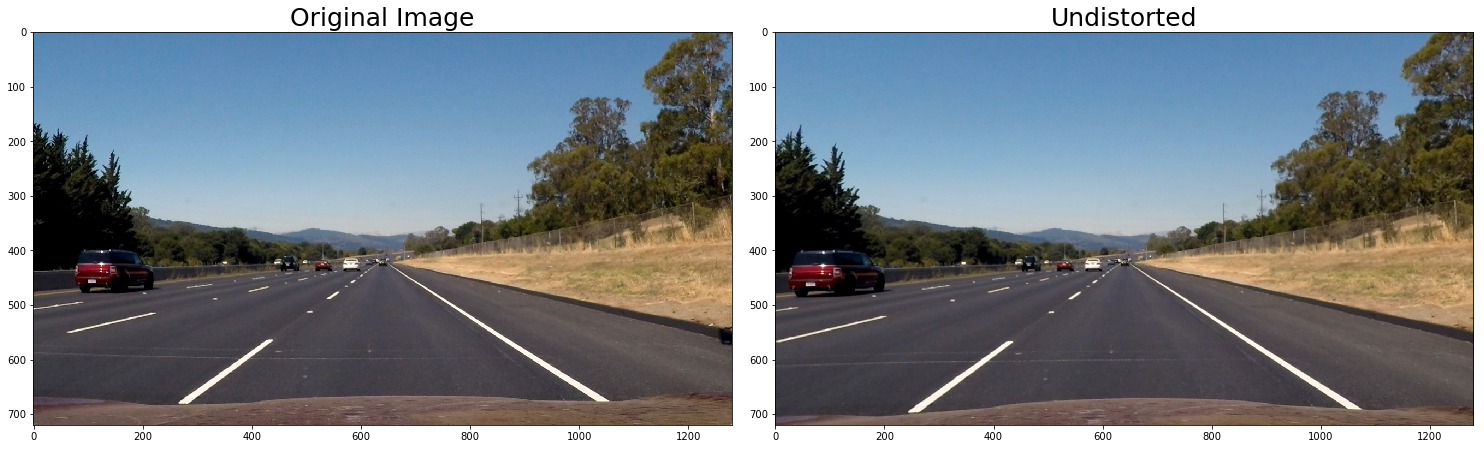

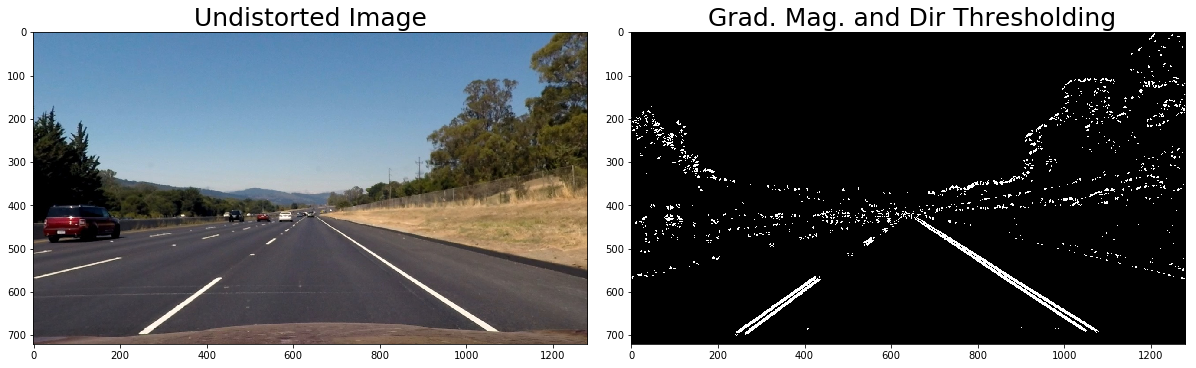

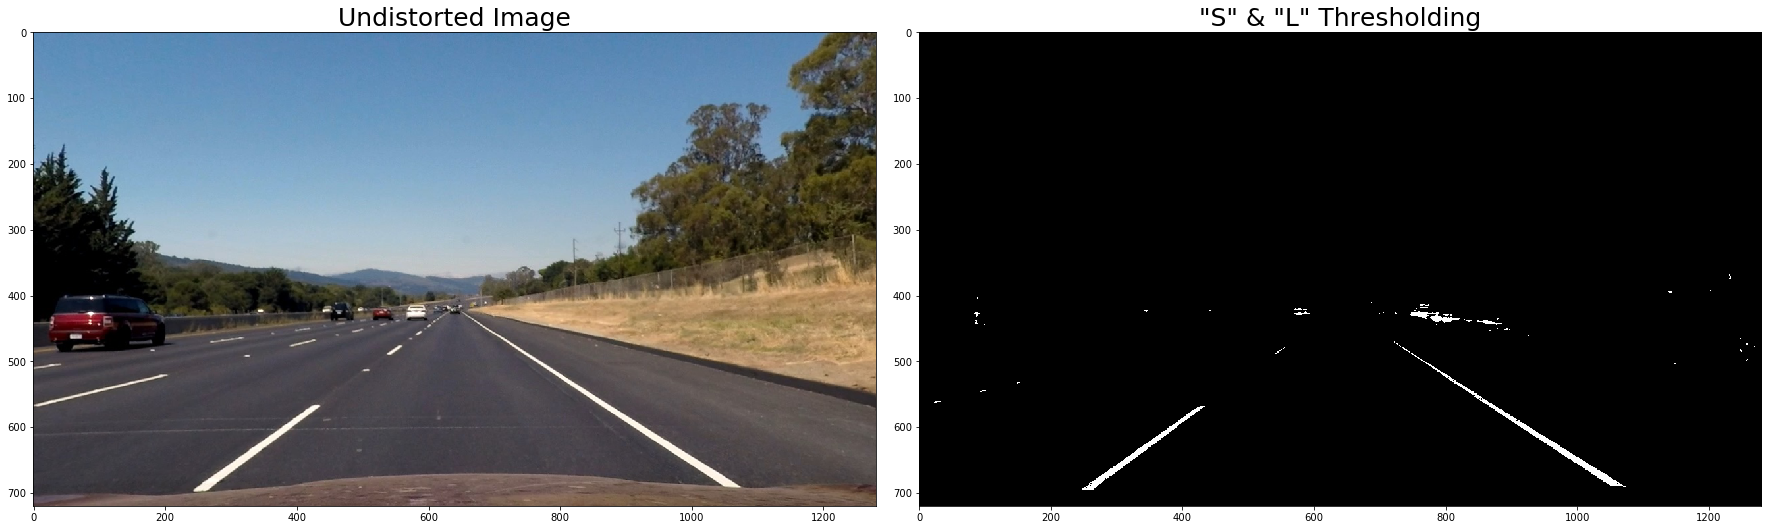

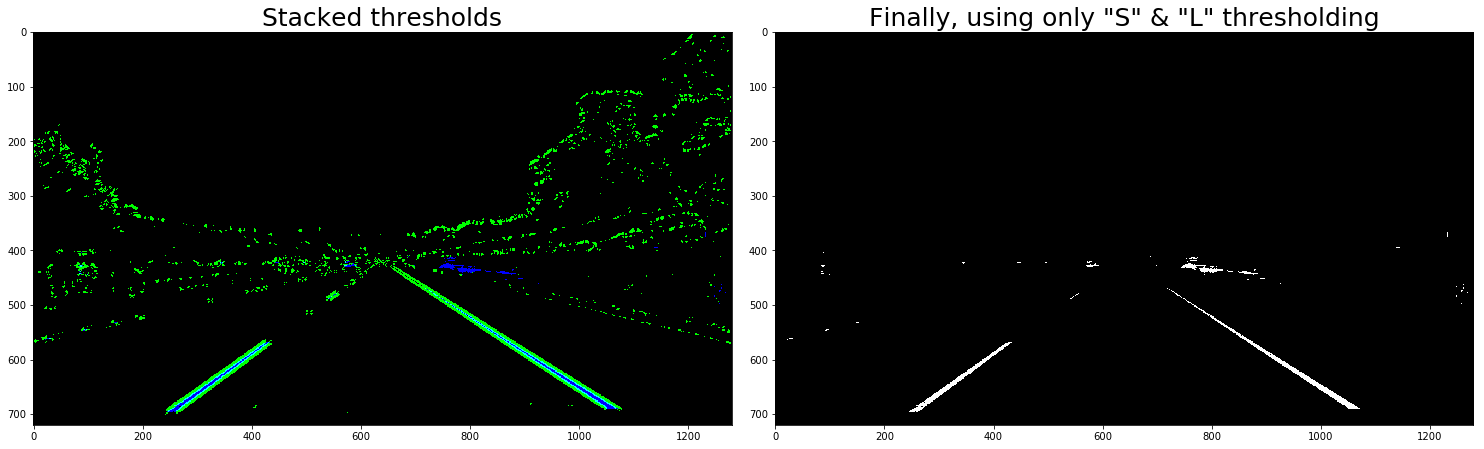

In [68]:
########################################
### Gradient and Color Thresholding ####
########################################

img = test_images[1]
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img,cmap='gray')
ax2.set_title('Undistorted', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# f.savefig('output_images/test_img_dist.jpg')

### Gradient Binary ###

def abs_sobel_thresh(img,orient='x',sobel_kernel=3, thresh=(0,255)):

	gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
	if orient== 'x':
		grad = cv2.Sobel(gray_img, cv2.CV_64F,1,0,ksize = sobel_kernel)
		grad = (grad/np.max(np.absolute(grad)))*255
	elif orient=='y':
		grad = cv2.Sobel(gray_img, cv2.CV_64F,0,1,ksize = sobel_kernel)
		grad = (grad/np.max(np.absolute(grad)))*255
	else:
		raise("Incorrect orientation choice: choose 'x' or 'y'")

	grad_binary = np.zeros_like(grad)
	grad_binary[(np.absolute(grad) > thresh[0]) & (np.absolute(grad)<=thresh[1])] = 1

	return grad_binary

def mag_thresh(img, sobel_kernel=3,mag_thresh=(0,255)):
    # calculating and thresholding the gradient magnitude
	gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
	gradX = cv2.Sobel(gray_img, cv2.CV_64F,1,0,ksize = sobel_kernel)
	gradY = cv2.Sobel(gray_img, cv2.CV_64F,0,1,ksize = sobel_kernel)
	gradMag = np.sqrt(np.square(gradX) + np.square(gradY))
	gradMag = (gradMag/np.max(gradMag))*255
	gradMag_binary = np.zeros_like(gradMag)
	gradMag_binary[(gradMag > mag_thresh[0]) & (gradMag <= mag_thresh[1])] = 1
	return gradMag_binary

def dir_threshold(img,sobel_kernel = 3, thresh=(0, np.pi/2)):
    # calcualting and thresholding the gradient direction
	gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gradX = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize = sobel_kernel)
	gradY = cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize = sobel_kernel)
	dir = np.arctan2(np.absolute(gradY),np.absolute(gradX))
	dir_binary = np.zeros_like(dir)
	dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
	return dir_binary


# Choose a Sobel kernel size
ksize = 15

# Apply each of the thresholding functions
gradX = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel = ksize, thresh=(40,255))
gradY = abs_sobel_thresh(undistorted_img, orient='y', sobel_kernel = ksize, thresh=(40,255))
mag_binary = mag_thresh(undistorted_img, sobel_kernel=ksize, mag_thresh=(40,255))
dir_binary = dir_threshold(undistorted_img, sobel_kernel=ksize, thresh=(0.6, 1.3))

combined = np.zeros_like(dir_binary)
# combined[((gradX == 1) & (gradY == 1))| ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradX == 1) & (gradY == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title(' Grad. Mag. and Dir Thresholding', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_grad.jpg')

### Color Binary ###
def hls_select(img, threshS=(0, 255), threshL = (0,255)):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    binary_output = np.zeros_like(S)
    binary_output[((S > threshS[0]) & (S <= threshS[1])) & ((L > threshL[0]) & (L <= threshL[1]))] = 1
    return binary_output
    
hls_binary = hls_select(undistorted_img, threshS=(150, 255), threshL = (150,255))
hls_graddir_binary = np.zeros_like(hls_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Undistorted Image', fontsize=25)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('"S" & "L" Thresholding', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_hls.jpg')

### Combined color and gradient thresholding ###
color_grad_thresh = np.zeros_like(combined)
color_grad_thresh_stacked = np.uint8(np.dstack((np.zeros_like(combined), combined, hls_binary))*255)

# combining grad mag and dir thresh with "S" and "L" thresh
# color_grad_thresh[(combined == 1)|(hls_binary == 1)] = 1
# Using only color thresholding
color_grad_thresh[(hls_binary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(color_grad_thresh_stacked)
ax1.set_title('Stacked thresholds',fontsize=25)
ax2.imshow(color_grad_thresh, cmap='gray')
ax2.set_title('Finally, using only "S" & "L" thresholding',fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_stacked.jpg')

##############################################
##### Masking under a region of interest #####
##############################################

# def region_of_interest(img, vertices):
#     """
#     Applies an image mask.
    
#     Only keeps the region of the image defined by the polygon
#     formed from `vertices`. The rest of the image is set to black.
#     """
#     #defining a blank mask to start with
#     mask = np.zeros_like(img)   
    
#     #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
#     if len(img.shape) > 2:
#         channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
#         ignore_mask_color = (255,) * channel_count
#     else:
#         ignore_mask_color = 255
        
#     #filling pixels inside the polygon defined by "vertices" with the fill color    
#     cv2.fillPoly(mask, vertices, ignore_mask_color)
    
#     #returning the image only where mask pixels are nonzero
#     masked_image = cv2.bitwise_and(img*255, mask)
#     return masked_image/255

# Masking
# masking_pts = np.int32(np.array([[[50,720],[580,450],[color_grad_thresh.shape[1]-520,450],[color_grad_thresh.shape[1]-50,720]]]))
# masked_img = region_of_interest(color_grad_thresh, masking_pts)

# Drawing mask on input image
# masked_annot_undistorted = np.copy(undistorted_img)
# cv2.polylines(masked_annot_undistorted,masking_pts,True,(255,0,0), 5)

# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# f.tight_layout()
# ax1.imshow(masked_annot_undistorted,  cmap='gray')
# ax1.set_title('Mask-Annotated Undistorted Image',fontsize=25)
# ax2.imshow(masked_img, cmap='gray')
# ax2.set_title('Masked Image',fontsize=25)
# plt.show()


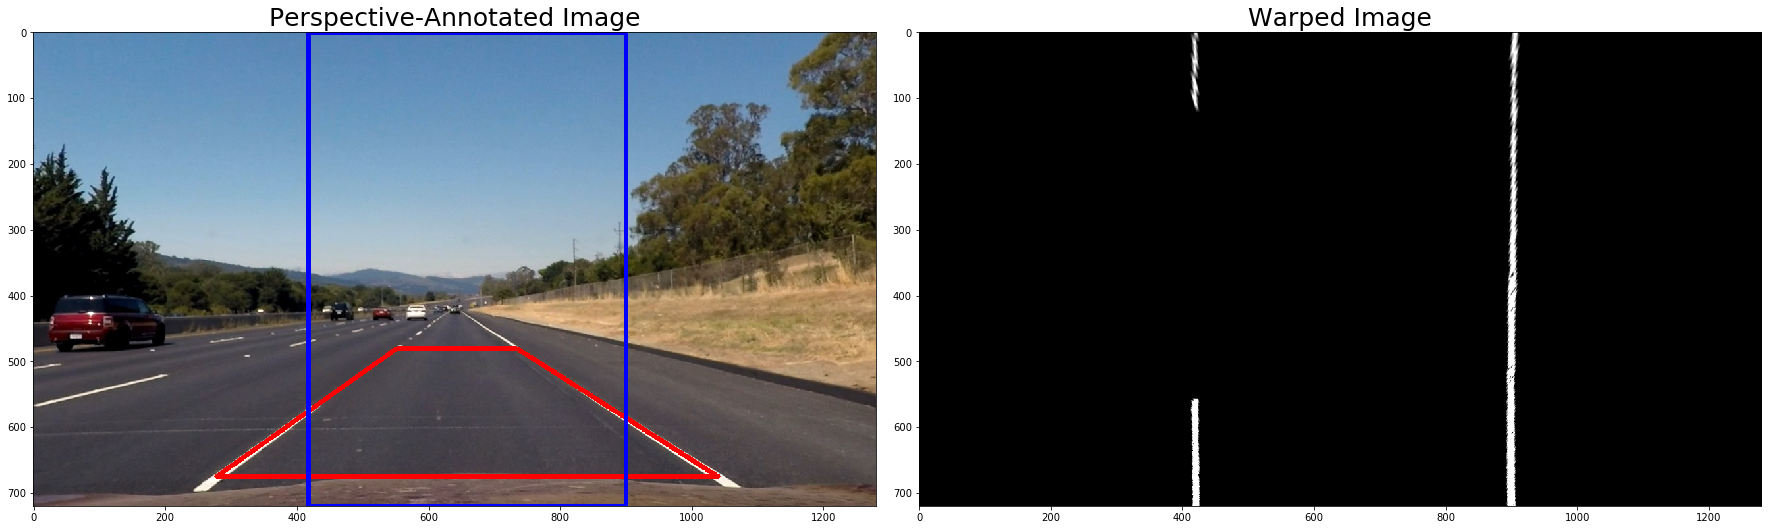

In [69]:
########################################
######### Perpective Transform #########
########################################

def image_warp(src,dst,img):
    # Here, img should be undistorted
    src = np.float32(src)
    dst = np.float32(dst)
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, M, Minv

def draw_lines(img, pts, color = (255,0,0)):
   
    cv2.polylines(img,[pts],True,color, 5)
    
src_pts = np.array([[278,675],[552,480],[734,480],[1040,675]]) # based on test_images[1]
dst_pts = np.array([[418,720],[418,0],[900,0],[900,720]])

annotated_img = np.copy(undistorted_img)

draw_lines(annotated_img,src_pts)
draw_lines(annotated_img,dst_pts,(0,0,255))

# warped_img, M, Minv = image_warp(src_pts, dst_pts,masked_img)
warped_img, M, Minv = image_warp(src_pts, dst_pts,color_grad_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(annotated_img)
ax1.set_title('Perspective-Annotated Image', fontsize=25)
ax2.imshow(warped_img, cmap = 'gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_warp.jpg')
    

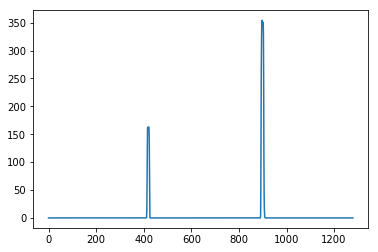

Left: 5.91111355477e-06 -0.0026689339436 418.51285557
Right: 3.38669911233e-06 -0.0114518848778 904.306498269


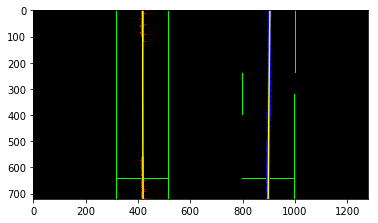

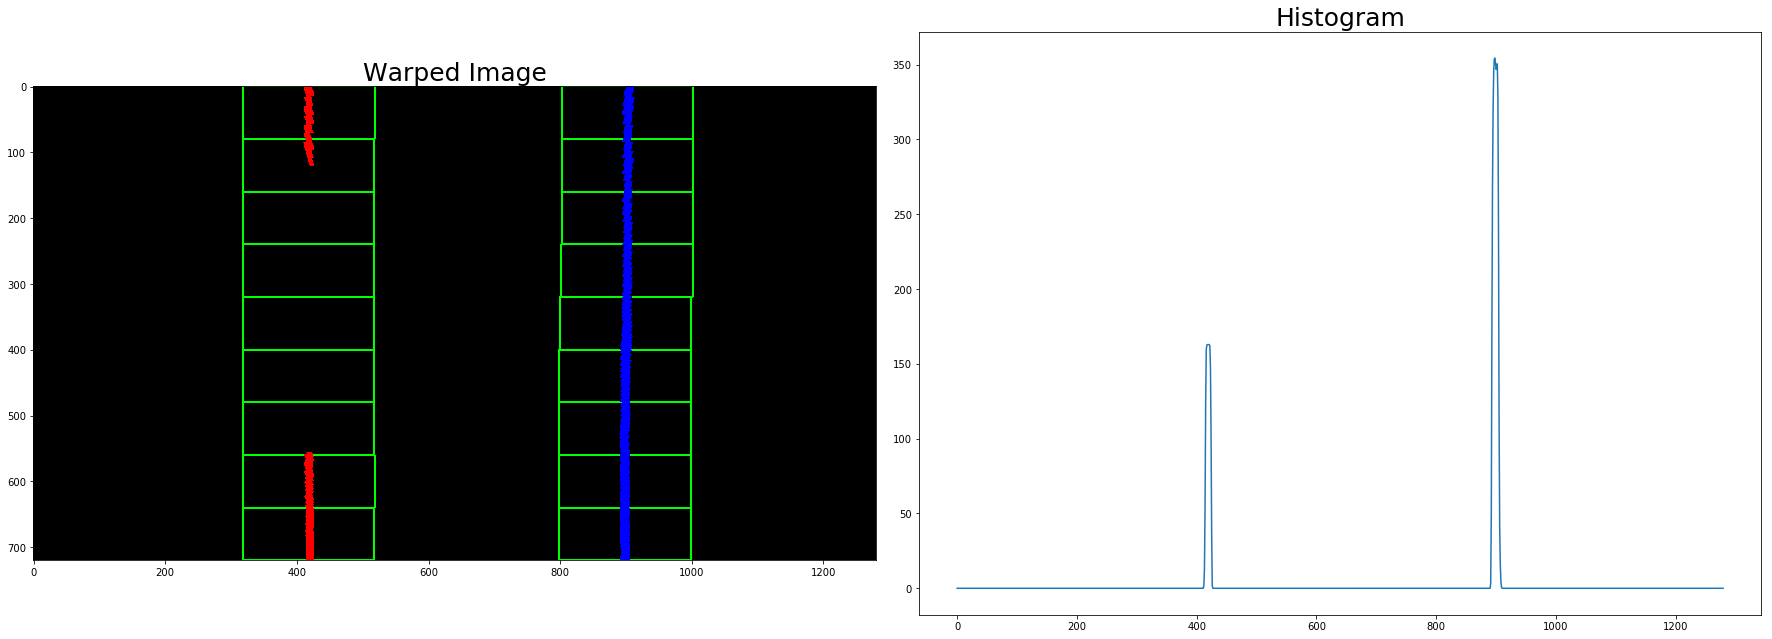

In [70]:
########################################
############ Finding Lanes #############
########################################

histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_img, warped_img, warped_img))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_img.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_img.shape[0] - (window+1)*window_height
    win_y_high = warped_img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255*255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255*255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print("Left:", left_fit[0], left_fit[1], left_fit[2])
print("Right:", right_fit[0], right_fit[1], right_fit[2])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255*255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255*255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Warped Image', fontsize=25)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_histogram.jpg')

(720, 0)

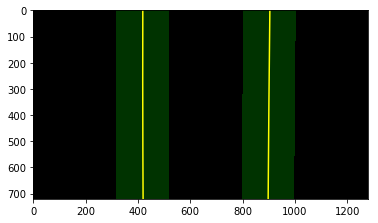

In [71]:
## Visualization

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_img, warped_img, warped_img))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result_vis = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result_vis)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [72]:
#####################################################
########### Measuring radius of curvature ###########
#####################################################

lwPixel = 480  # lane width in pixels

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/lwPixel  # meters per pixel in x dimension

y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
print(left_curverad/1000,'km ', right_curverad/1000,'km ')


19.0510312738 km  33.25151108 km 


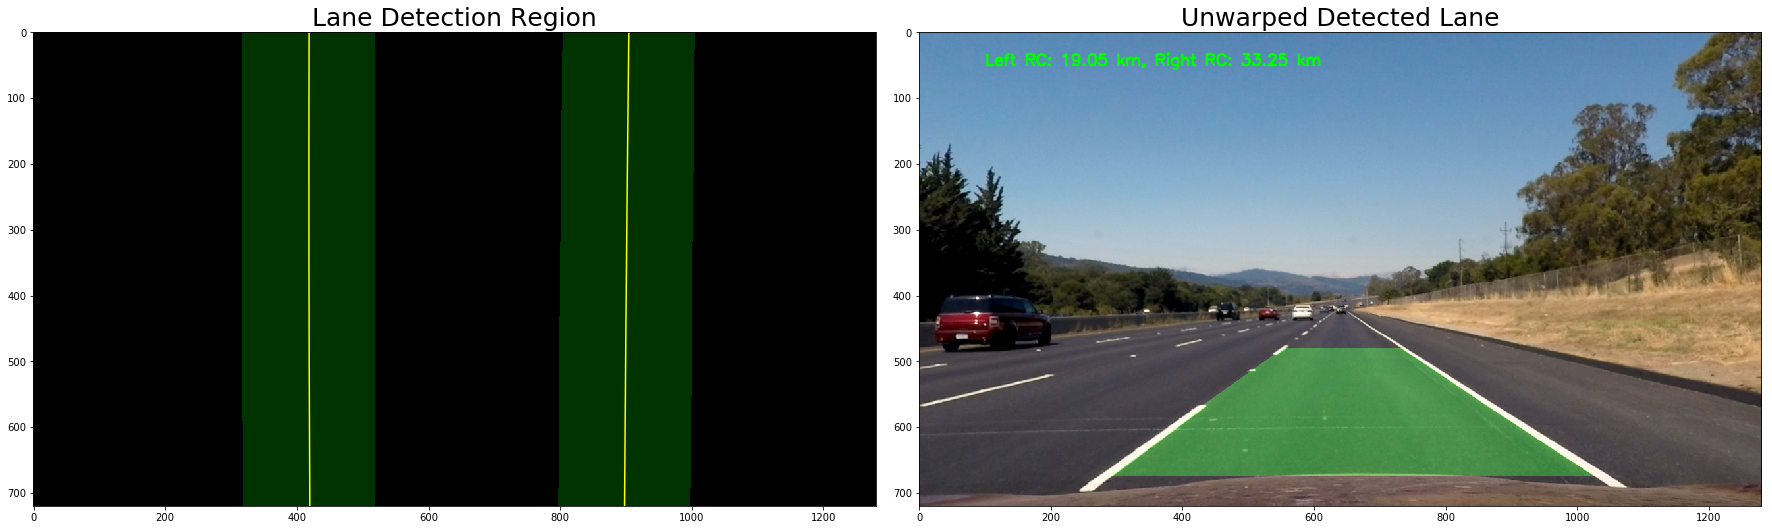

658.736545821 640.0 -0.144427540701


In [73]:
## Unwarping and drawing

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
font = cv2.FONT_HERSHEY_SIMPLEX
text = 'Left RC: {:.2f} km, Right RC: {:.2f} km'.format(left_curverad/1000,right_curverad/1000)
cv2.putText(result, text, (100, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
# plt.imshow(result)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result_vis)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Lane Detection Region', fontsize=25)
ax2.imshow(result)
ax2.set_title('Unwarped Detected Lane', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# f.savefig('output_images/test_img_unwarp.jpg')
# f.savefig('output_images/test_img_unwarp_curved.jpg')

lane_center = (left_fitx[left_fitx.shape[0]-1] + right_fitx[right_fitx.shape[0]-1])/2
image_center = warp_zero.shape[1]/2
offset = (image_center - lane_center)*xm_per_pix
print(lane_center, image_center, offset)

In [74]:
def meanLaneWidth(left_fitx, right_fitx, ploty):
    # calcualtes averae horizontal distance
    # between left and right lane lines
    dataLength = ploty.size
    intervalSize = dataLength//50
    laneWidth = []
    for i in range(0,dataLength, intervalSize):
        dist = right_fitx[i] - left_fitx[i]
        laneWidth.append(dist)
    
    laneWidth = np.array(laneWidth)
    meanLaneWidth = np.mean(laneWidth)
    stddevLaneWidth = np.std(laneWidth)
    
    return meanLaneWidth, stddevLaneWidth

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
#         self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
#         self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
#         self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False]) 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
#         self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Does this lane has more data points in histogram
        self.dominantLine = False
        #Flags true when the lane is detected the very first time
        self.firstFrame = False

leftLine = Line()
rightLine = Line()

# Implementation on Video

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

src_pts = np.array([[278,675],[552,480],[734,480],[1040,675]]) # based on test_images[1]
dst_pts = np.array([[418,720],[418,0],[900,0],[900,720]])

lwMeandev = 0.1 # percent
lwStddev = 5 # pixels

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/lwPixel # meters per pixel in x dimension

y_eval = np.max(ploty)
min_points = 3 # minimum number of detected points to call it a considerable line

def process_image(image):
    # NOTE: The output is a color image (3 channel) for processing video below
    # The final output is the image where (transparent) lines are drawn on lanes
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Choose a Sobel kernel size
    ksize = 15
    
    # Frame smoothing factor
    alpha = 0.5
    
    # color thresholding
    hls_binary = hls_select(undistorted_img, threshS=(150, 255), threshL = (150,255))

    # Perspective Transform
    warped_img, M, Minv = image_warp(src_pts, dst_pts,hls_binary)

    # Finding Lanes

    if ((leftLine.detected == False) or (rightLine.detected == False)): 

        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # choose the line with more data points for Radius of Curv. display
        if histogram[leftx_base] >= histogram[rightx_base]:
            leftLine.dominantLine = True
            rightLine.dominantLine = False
        else:
            leftLine.dominantLine = False
            rightLine.dominantLine = True
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(warped_img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # When no history data points available
        if ((leftLine.allx == None) or (rightLine.allx == None)):
            if ((leftx.size < min_points) or (rightx.size < min_points)):
                pass
            else:
                leftLine.firstFrame = True
                rightLine.firstFrame = True
                leftLine.allx = leftx
                leftLine.ally = lefty
                rightLine.allx = rightx
                rightLine.ally = righty

        # Fit a second order polynomial to each
        if ((leftLine.firstFrame == True) and (rightLine.firstFrame == True)):
            if leftx.size < min_points:

                leftx = leftLine.allx
                lefty = leftLine.ally
                rightx = rightLine.allx
                righty = rightLine.ally

            left_fit = np.polyfit(lefty, leftx, 2) 

            if leftLine.current_fit.size == 3:
                left_fit = alpha*left_fit + (1 - alpha)*leftLine.current_fit

            if rightx.size < min_points:

                rightx = rightLine.allx
                righty = rightLine.ally
                leftx = leftLine.allx
                lefty = leftLine.ally

            right_fit = np.polyfit(righty, rightx, 2)

            if rightLine.current_fit.size == 3:
                right_fit = alpha*right_fit + (1 - alpha)*rightLine.current_fit                    

            # Generate x and y values for plotting
            ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            mean, stddev = meanLaneWidth(left_fitx, right_fitx, ploty)

            # ensuring mean lane width and std. deviation is within bounds
            if ((abs(mean - lwPixel) < lwMeandev*lwPixel)  and (stddev < lwStddev)):
                
                leftLine.current_fit = left_fit           
                rightLine.current_fit = right_fit
                leftLine.allx = leftx
                leftLine.ally = lefty
                rightLine.allx = rightx
                rightLine.ally = righty
                leftLine.detected = True
                rightLine.detected = True
                
            else:
                leftLine.detected = False
                rightLine.detected = False
                if ((leftLine.allx is not None) and (rightLine.allx is not None)):
                    leftx = leftLine.allx
                    lefty = leftLine.ally
                    rightx = rightLine.allx
                    righty = rightLine.ally

                if leftLine.current_fit.size == 3:
                    left_fit = leftLine.current_fit
                else:
                    leftLine.current_fit = left_fit
                left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]

                if rightLine.current_fit.size == 3: 
                    right_fit = rightLine.current_fit
                else:
                    rightLine.current_fit = right_fit
                right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

            if (leftLine.dominantLine == True):
                curverad = left_curverad
            else:
                curverad = right_curverad

            leftLine.radius_of_curvature = curverad
            rightLine.radius_of_curvature = curverad        

            ## Unwarping and drawing
            # Create an image to draw the lines on
            warp_zero = np.zeros_like(warped_img).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

            # Combine the result with the original image
            result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
        else:
            result = undistorted_img
        
    else:
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
       
        left_fit = leftLine.current_fit 
        right_fit = rightLine.current_fit
  
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        if (leftx.shape[0] > min_points):
            # Extract left and right line pixel positions
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fit = alpha*left_fit + (1 - alpha)*leftLine.current_fit
        else:
            leftx = leftLine.allx
            lefty = leftLine.ally
            rightx = rightLine.allx
            righty = rightLine.ally
            
        if (rightx.shape[0] > min_points):
            # Again, extract left and right line pixel positions
            # Fit a second order polynomial to each
            right_fit = np.polyfit(righty, rightx, 2)
            right_fit = alpha*right_fit + (1 - alpha)*rightLine.current_fit
        else:
            rightx = rightLine.allx
            righty = rightLine.ally
            leftx = leftLine.allx
            lefty = leftLine.ally
            
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        mean, stddev = meanLaneWidth(left_fitx, right_fitx, ploty)
        
        # ensuring mean lane width and std. deviation is within bounds        
        if ((abs(mean - lwPixel) < lwMeandev*lwPixel)  and (stddev < lwStddev)):
            leftLine.current_fit = left_fit
            rightLine.current_fit = right_fit
            leftLine.allx = leftx
            leftLine.ally = lefty   
            rightLine.allx = rightx
            rightLine.ally = righty
            leftLine.detected = True
            rightLine.detected = True
        else:
            leftLine.detected = False
            rightLine.detected = False
            
            if ((leftLine.allx is not None) and (rightLine.allx.size is not None)):
                leftx = leftLine.allx 
                lefty = leftLine.ally
                rightx = rightLine.allx
                righty = rightLine.ally
            
            if leftLine.current_fit.size == 3:
                left_fit = leftLine.current_fit
            else:
                leftLine.current_fit = left_fit
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            if rightLine.current_fit.size == 3: 
                right_fit = rightLine.current_fit
            else:
                rightLine.current_fit = right_fit
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        if (leftLine.dominantLine == True):
            curverad = left_curverad
        else:
            curverad = right_curverad     
            
        leftLine.radius_of_curvature = curverad
        rightLine.radius_of_curvature = curverad 

        ## Unwarping and drawing

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        
        result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
        
    if ((leftLine.firstFrame == True) and (rightLine.firstFrame == True)):
        lane_center = (left_fitx[left_fitx.shape[0]-1] + right_fitx[right_fitx.shape[0]-1])/2
        image_center = warp_zero.shape[1]/2
        offset = (image_center - lane_center)*xm_per_pix

        if curverad is not None:
            text1 = 'Radius of Curv. {:.2f} km'.format(curverad/1000)
            if (offset >= 0):
                text2 = ' Vehicle {:.2f} m right of center'.format(abs(offset))
            else:
                text2 = ' Vehicle {:.2f} m left of center'.format(abs(offset))
            text = text1 + text2
            cv2.putText(result, text, (100, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    return result

white_output = 'output_videos/project_video_annotated.mp4'
# white_output = 'output_videos/challenge_video_annotated.mp4'
# white_output = 'output_videos/harder_challenge_video_annotated.mp4'

clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("challenge_video.mp4")
# clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


[MoviePy] >>>> Building video output_videos/project_video_annotated.mp4
[MoviePy] Writing video output_videos/project_video_annotated.mp4


100%|█████████▉| 1260/1261 [05:04<00:00,  5.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_annotated.mp4 

CPU times: user 3min 57s, sys: 7.85 s, total: 4min 4s
Wall time: 5min 6s
